# Time-series forecasting

**Objectuve:** Predict future data points in a time-series of atmospheric CO2 concentration measured at Mauna Loa Observatory.

**Forecasting algorithms:** We will use AutoRegressive model for this analysis.

# **Load and explore the data**

In [1]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We will download the [data](https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.txt) directly from [The Global Monitoring Laboratory (GML) of the National Oceanic and Atmospheric Administration](https://gml.noaa.gov).

The data includes atmospheric CO2 concentration measured at constant time intervals at the Mauna Loa Observatory (MLO), Hawaii, United States.

In [3]:
# download the data
url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt"
names = ["year", "month", "day", "year_decimal", "co2", "days", "1 yr ago",
          "10 yr ago", "since 1800"]
maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                       names=names, na_values=[-999.99])
maunaloa.head()

,year,month,day,year_decimal,co2,days,1 yr ago,10 yr ago,since 1800
0,1974,5,19,1974.3795,333.37,5,NaN,NaN,50.40
1,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974,6,2,1974.4178,332.35,5,NaN,NaN,49.60
3,1974,6,9,1974.4370,332.20,7,NaN,NaN,49.65
4,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.06


In [4]:
# change the way data is organized
maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                       names=names, parse_dates=[[0, 1, 2]], na_values=[-999.99],
                       index_col="year_month_day")
maunaloa.head()

,year_decimal,co2,days,1 yr ago,10 yr ago,since 1800
year_month_day,,,,,,
1974-05-19,1974.3795,333.37,5,NaN,NaN,50.40
1974-05-26,1974.3986,332.95,6,NaN,NaN,50.06
1974-06-02,1974.4178,332.35,5,NaN,NaN,49.60
1974-06-09,1974.4370,332.20,7,NaN,NaN,49.65
1974-06-16,1974.4562,332.37,7,NaN,NaN,50.06


## Missing values

In [5]:
# check for missing missing values
missingVals = maunaloa.co2.isnull().sum()
print('Number of missing data points is %s from total data points of %s' 
      % (missingVals, len(maunaloa)))

Number of missing data points is 18 from total data points of 2458


In [6]:
# Fill the missing data points using available data
# ffill: propagate last valid observation forward to next valid backfill
# bfill: use next valid observation to fill gap.
maunaloa.fillna(method='ffill', inplace=True)
missingVals = maunaloa.co2.isnull().sum()
print('Number of missing data points is %s from total data points of %s' 
      % (missingVals, len(maunaloa)))

Number of missing data points is 0 from total data points of 2458


## Data visualization

Text(0.5, 1.0, 'Atmospheric CO2 at Mauna Loa Observatory')

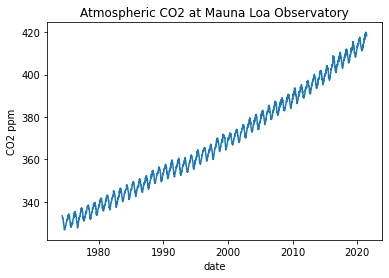

In [7]:
# data visualization
ppm = maunaloa.co2
plt.plot(ppm)
plt.xlabel('date')
plt.ylabel('CO2 ppm')
plt.title('Atmospheric CO2 at Mauna Loa Observatory')

## Stationarity

In [8]:
# Use adfuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(ppm)
print('ADF Statistic for original data: %.3f' % result[0])
print('p-value: %.3f' % result[1])

ADF Statistic for original data: 0.417
p-value: 0.982


The time-series is non-stationary.

## Autocorrelation

In [9]:
# measure autocorrelation at different lags
ppm = maunaloa.co2
ac = ppm.autocorr(lag=1)
print('Lag-1 autocorrelation = %.4f' % ac)

ac = ppm.autocorr(lag=25)
print('Lag-25 autocorrelation = %.4f' % ac)

Lag-1 autocorrelation = 0.9997
Lag-25 autocorrelation = 0.9850


Let's have a closer look at autocorrelation

Text(0.5, 1.0, 'original time series')

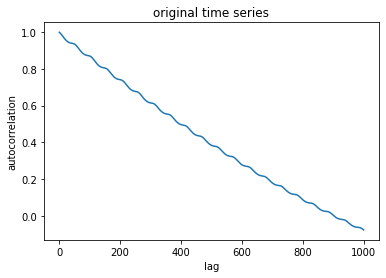

In [10]:
from statsmodels.tsa.stattools import acf
autocorrelation = acf(ppm, fft=False, nlags=1000) # nlags = 100
plt.plot(autocorrelation)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('original time series')

Data seems to be both seasonal and non-stationary.

## How to make the time-series stationary?

## Differencing

Text(0.5, 1.0, 'differencing')

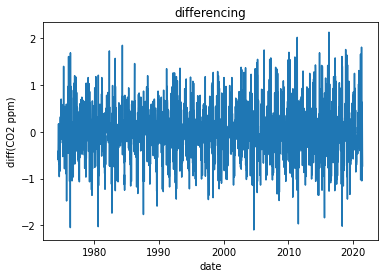

In [11]:
# find the difference of consecutive data points
plt.plot(ppm.diff())
plt.xlabel('date')
plt.ylabel('diff(CO2 ppm)')
plt.title('differencing')

In [12]:
# Let's see if differencing helps
result = adfuller(ppm.diff()[1:])
print('ADF Statistic for differenced data: %.3f' % result[0])
print('p-value: %s' % result[1])

ADF Statistic for differenced data: -15.952
p-value: 7.339418143638006e-29


Yes it does! How about the autocorrelation of the differenced time-series?

Text(0.5, 1.0, 'differenced time series')

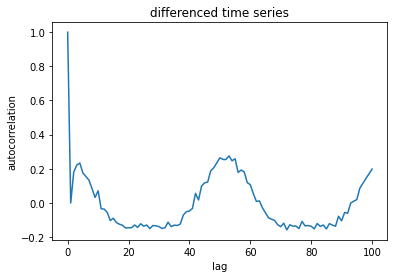

In [13]:
autocorrelation = acf(ppm.diff()[1:], fft=False, nlags=100)
plt.plot(autocorrelation)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('differenced time series')

Differenced time-series is still seasonal, but let's put that aside for now.

## Detrending

We can decompose the time-series to different components.

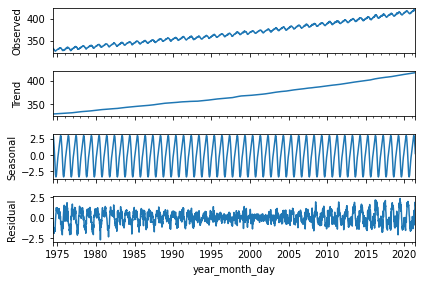

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ppm, model='additive', extrapolate_trend='freq')
fig = decomposition.plot()

Now let's detrend the time-series using the trend component from the decomposition analysis.

Text(0, 0.5, 'detrended CO2 ppm')

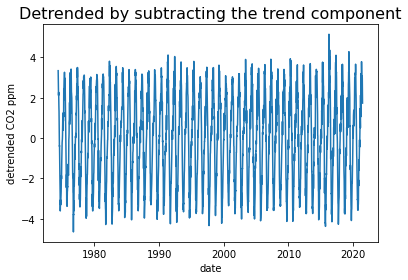

In [15]:
# Using statmodels: Subtracting the Trend Component
detrended = ppm - decomposition.trend
plt.plot(detrended)
plt.title('Detrended by subtracting the trend component', fontsize=16)
plt.xlabel('date')
plt.ylabel('detrended CO2 ppm')

In [16]:
# Let's check the stationarity stats
from statsmodels.tsa.stattools import adfuller
result = adfuller(detrended)
print('ADF Statistic for detrended data (statsmodel): %.3f' % result[0])
print('p-value: %s' % result[1])

ADF Statistic for detrended data (statsmodel): -25.391
p-value: 0.0


Yes deterending works (even better than differencing in this case).

Let's try another method to detrend the time-series.

Text(0.5, 1.0, 'Detrended by subtracting the least squares fit')

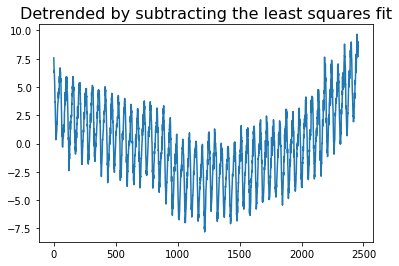

In [17]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(ppm)
plt.plot(detrended)
plt.title('Detrended by subtracting the least squares fit', fontsize=16)

In [18]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(detrended)
print('ADF Statistic for detrended data (scipy): %.3f' % result[0])
print('p-value: %s' % result[1])

ADF Statistic for detrended data (scipy): -4.214
p-value: 0.0006227415538645748


It works, but not as good as removing the trend from decomposition analysis.

# **Time-series forecasting: AutoRegressive model**

## **Train/test data split**

Since the data is sequential in time (order of data points matter), we will select the first 75% of data points as training set and the remaining 25% as test set.

In [19]:
# define the split point to split the data into 75%/25% ratio.
split_point = np.floor(0.75*(len(ppm))).astype(int)

# define train and test sets
train = ppm[:split_point]
test = ppm[split_point:]

print('Training set shape: %s \nTest set shape: %s' 
      % (train.shape, test.shape))

Training set shape: (1843,) 
Test set shape: (615,)


## **AutoRegressive model**

In [22]:
from statsmodels.tsa import ar_model
# train AutoRegressive model using training set
ar_model = ar_model.AR(train)
ar_model_fit = ar_model.fit(maxlag=50)

Text(0, 0.5, 'CO2 ppm')

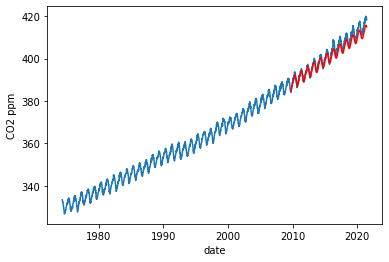

In [23]:
# predict and plot time-series values for test data using test set index
predicted_values_ar = ar_model_fit.predict(test.index[0], test.index[-1])
plt.plot(ppm)
plt.plot(predicted_values_ar, 'red')
plt.xlabel('date')
plt.ylabel('CO2 ppm')

We're doing pretty good! Let's try combining AutoRegressive model with Regression analysis!

## **AutoRegressive model with Regression analysis**

For Regression analysis, we need to convert dates to ordinal values. 
*   The function `toordinal()` returns the proleptic Gregorian ordinal of a date.
*   In simple terms `datetime.toordinal()` returns the day count from the date 01/01/01

In [24]:
# convert date in the dataset to ordinal values
X = ppm.index.to_series().apply(lambda x: x.toordinal())
X = pd.DataFrame(X)
# split the ordinal data to train and test sets for regression analysis
X_train, X_test = X.iloc[:split_point, :], X.iloc[split_point:, :]

Text(0, 0.5, 'CO2 ppm')

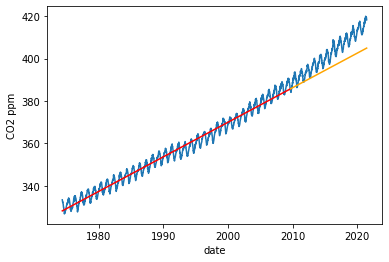

In [25]:
from sklearn.linear_model import LinearRegression
# train LinearRegression model using ordinal data as X and time-series values from train set as y
lr = LinearRegression().fit(X_train, train)
# predict time-series values for ordinal test data
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)

# plot real vs predicted (here predicted is a line of best fit)
plt.plot(ppm)
plt.plot(train.index, lr_pred_train, 'red')
plt.plot(test.index, lr_pred_test, 'orange')
plt.xlabel('date')
plt.ylabel('CO2 ppm')

The fit is ok, but it seems like a polynomial fit might work better.

Text(0, 0.5, 'CO2 ppm')

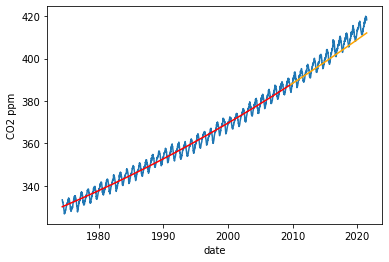

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# train the polynomial model (quadratic)
lr_poly = make_pipeline(PolynomialFeatures(degree=2,include_bias=False), LinearRegression())
lr_poly.fit(X_train, train)

# predict time-series values for ordinal test data
lr_poly_pred_train = lr_poly.predict(X_train)
lr_poly_pred_test = lr_poly.predict(X_test)

# plot real vs predicted (here predicted is a the quadratic fit)
plt.plot(ppm)
plt.plot(train.index, lr_poly_pred_train, 'red')
plt.plot(test.index, lr_poly_pred_test, 'orange')
plt.xlabel('date')
plt.ylabel('CO2 ppm')

Perfect! Polynomial fit works better!

Now let's remove the polynomial fit from original time-series (residualizing) and fit a new AutoRegressive model to the residualized ata.

Text(0, 0.5, 'residuals')

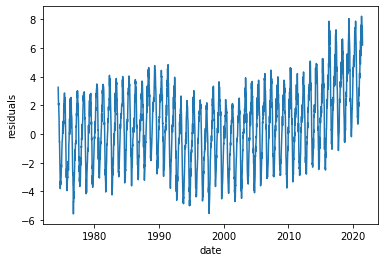

In [27]:
# find residuals by removing the polynomial fit
y_res = ppm - lr_poly.predict(X)
plt.plot(y_res)
plt.xlabel('date')
plt.ylabel('residuals')

Use the residuals and make new train/test split, then fit an AutoRegressive model.

In [28]:
from statsmodels.tsa import ar_model
# split the residuals to train/test sets as before
train_res = y_res[:split_point]
test_res = y_res[split_point:]

# train an AutoRegressive model with resiudalized data
ar_model_res = ar_model.AR(train_res)
ar_model_res_fit = ar_model_res.fit(maxlag=50)

# predict residualized test data
ar_pred_res = ar_model_res_fit.predict(
        test_res.index[0], test_res.index[-1])

# calculate final values as the sum of predicted values from the 
# new AutoRegressive model and Polynomial fit
predicted_values_ar_res_poly = ar_pred_res + lr_poly_pred_test

Text(0, 0.5, 'CO2 ppm')

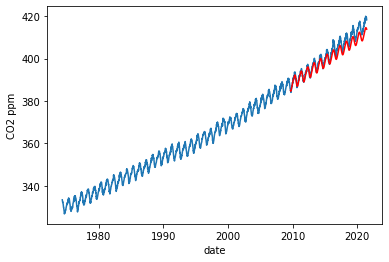

In [29]:
# plot predicted values using the combination of AutoRegssive and Polynomial models
plt.plot(ppm)
plt.plot(predicted_values_ar_res_poly, 'red')
plt.xlabel('date')
plt.ylabel('CO2 ppm')

This is pretty similar to what we got using AutoRegressive model only. Let's compare the two model fits.

Text(0, 0.5, 'CO2 ppm')

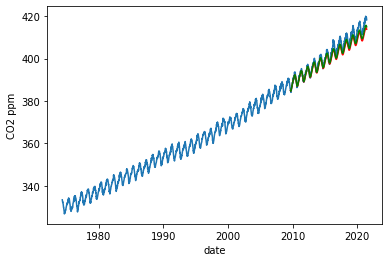

In [30]:
# plot predicted values using the combination of AutoRegssive and Polynomial models (in red) 
# and using an AutoRegressive model only (in green).
plt.plot(ppm)
plt.plot(predicted_values_ar_res_poly, 'red')
plt.plot(predicted_values_ar, 'green')
plt.xlabel('date')
plt.ylabel('CO2 ppm')

It seems like AutoRegressive model performs better! (without Polynomial fit). Let's check the coefficient of determination (R2).

In [31]:
from sklearn.metrics import r2_score
polyAR_score = r2_score(test, predicted_values_ar_res_poly)
AR_score = r2_score(test, predicted_values_ar)

print('Polynomial fit + AutoRegressive model: \nR2 score = %.3f' % polyAR_score)
print('\nAutoRegressive model: \nR2 score = %.3f' % AR_score)

Polynomial fit + AutoRegressive model: 
R2 score = 0.922

AutoRegressive model: 
R2 score = 0.954
